In [1]:
!pip3 install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.1/434.1 MB 21.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyspark: filename=pyspark-4.0.0-py2.py3-none-any.whl size=434741299 sha256=4c66e51d344fd7eb7cefc92fb71ea668b25f08ee91f219e9792121881f937231
  Stored in directory: /home/codespace/.cache/pip/wheels/2d/77/9b/12660be70f7f447940a0caede37ae208b2e0d1c8487dce52a6
Successfully built pyspark

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
from pyspark.sql import SparkSession, functions as F, types as T
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder, Imputer

In [2]:
spark = SparkSession.builder.appName('titanic').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/14 17:52:03 WARN Utils: Your hostname, codespaces-589634, resolves to a loopback address: 127.0.0.1; using 10.0.2.171 instead (on interface eth0)
25/06/14 17:52:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/14 17:52:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/14 17:52:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [76]:
train = spark.read.csv('train.csv', header = True)
test = spark.read.csv('test.csv', header = True)

In [77]:
train.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                NULL|  NULL| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

In [78]:
train.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [79]:
labelCol = 'Survived'

In [80]:
numerical_cols = ['Fare', 'Age', 'SibSp', 'Parch']

In [81]:
def convert_to_numbers(df):
    for col in numerical_cols:
        df = df.withColumn(col, F.col(col).cast(T.FloatType()))
    return df

In [82]:
train = convert_to_numbers(train)

In [83]:
import matplotlib.pyplot as plt
def plot_dist(df, col, bin_size = 5, is_categorical = False):

    if not is_categorical : df = df.withColumn(f'{col}_bin', (F.col(col) / bin_size).cast(T.IntegerType()))
    if is_categorical: df = df.withColumn(f'{col}_bin', F.col(col))
    counts = df.groupby(f'{col}_bin', labelCol).agg(F.count(F.lit(1)).alias('counts')).orderBy(f'{col}_bin').fillna(-1, [f'{col}_bin']).toPandas()
    counts = counts.pivot(index=f'{col}_bin', columns=labelCol, values='counts').fillna(0)
    counts = counts.sort_index()
    counts.plot(kind = 'bar', stacked = True)
    #plt.hist(counts['counts'])


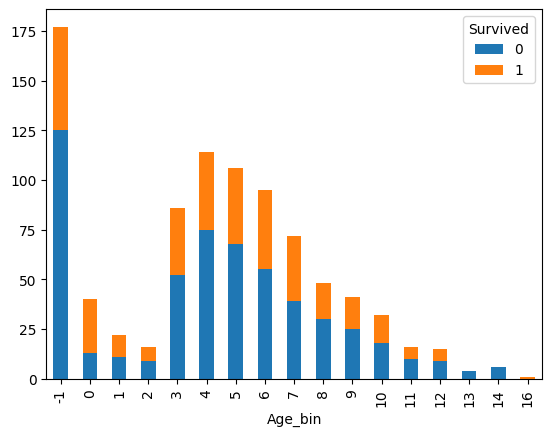

In [84]:
plot_dist(train, 'Age')

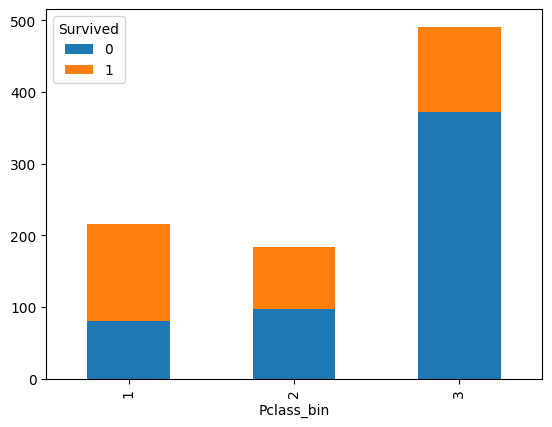

In [85]:
plot_dist(train, 'Pclass', bin_size = 1)

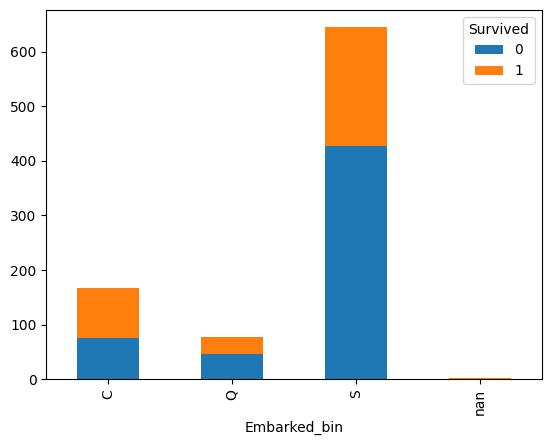

In [86]:
plot_dist(train, 'Embarked', bin_size = 1, is_categorical = True)

In [87]:
train = train.withColumn('family_size', F.col('SibSp') + F.col('ParCh'))

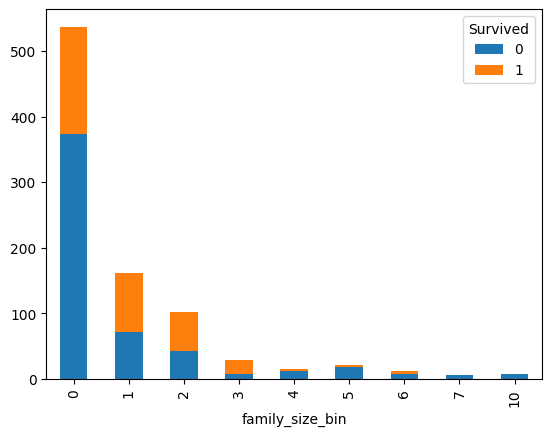

In [88]:
plot_dist(train, 'family_size',  bin_size=1)

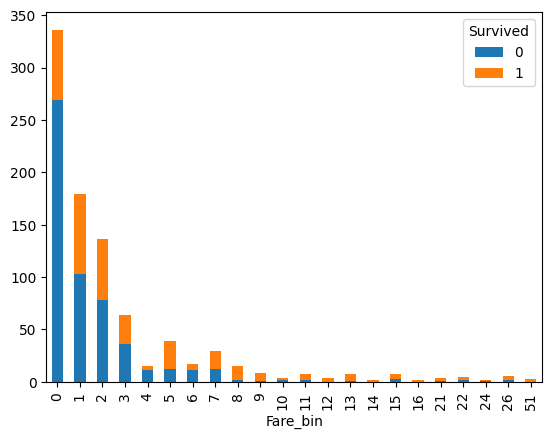

In [89]:
plot_dist(train, 'Fare', bin_size= 10 )

In [90]:
train = train.withColumn('CabinID', F.udf(lambda x : x[0] if x else 'missing', returnType=T.StringType())('Cabin'))
train = train.fillna('missing', ['CabinID'])

In [91]:
train

DataFrame[PassengerId: string, Survived: string, Pclass: string, Name: string, Sex: string, Age: float, SibSp: float, Parch: float, Ticket: string, Fare: float, Cabin: string, Embarked: string, family_size: float, CabinID: string]

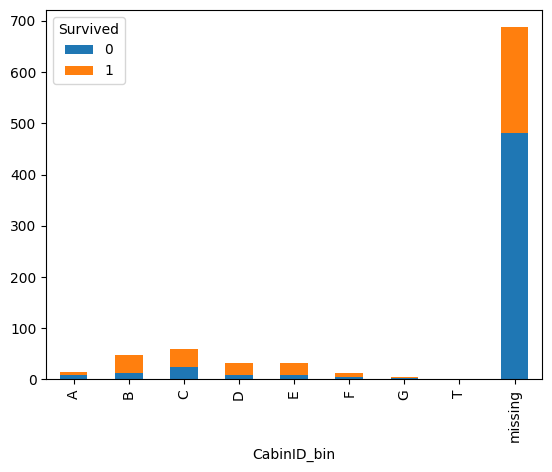

In [92]:
plot_dist(train, 'CabinID', bin_size=1, is_categorical=True)

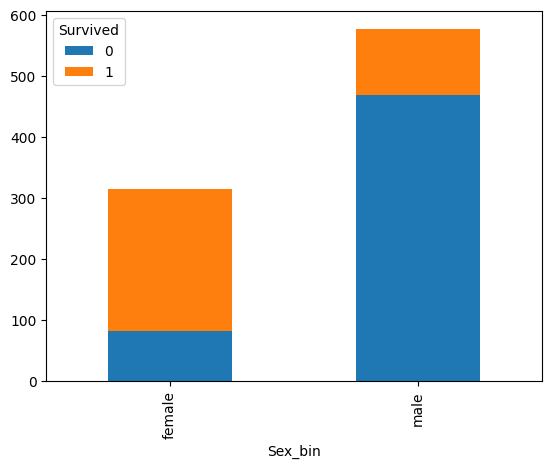

In [93]:
plot_dist(train, 'Sex', is_categorical=True)

In [94]:
train.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'family_size',
 'CabinID']

In [95]:
train.describe().show()

+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+------------------+-------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|       family_size|CabinID|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+------------------+-------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|               891|    891|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|      

In [96]:
def preprocess(df):
    df = convert_to_numbers(df)

    df = df.withColumn('Age_bin', (F.col('Age') / 5).cast(T.IntegerType()) )
    df = df.withColumn('family_size', F.col('SibSp') + F.col('ParCh'))
    df = df.withColumn('CabinID', F.udf(lambda x : x[0] if x else 'missing', returnType=T.StringType())('Cabin'))
    
    df = df.fillna(-1, 'Age_bin')
    df = df.fillna('S' , 'Embarked')

    if labelCol in df.columns : df = df.withColumn(labelCol, F.col(labelCol).cast(T.IntegerType()))

    return df
    
    

In [97]:
train= preprocess(train)
test = preprocess(test )

In [98]:
train.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'family_size',
 'CabinID',
 'Age_bin']

In [99]:
categorical_cols = ['Age_bin', 'CabinID', 'Embarked' , 'Sex', 'Pclass']
numerical_cols = ['Fare',  'family_size']

In [100]:
from pyspark.ml.pipeline import Pipeline

In [101]:
pipeline_model = Pipeline( stages = [
    VectorAssembler(inputCols=numerical_cols, outputCol='num_features'),
    StandardScaler( inputCol= 'num_features', outputCol= 'num_features_scaled', withMean=True, withStd=True),
    StringIndexer(inputCols=categorical_cols, outputCols=[f'{col}_index' for col in categorical_cols]),
    OneHotEncoder(inputCols=[f'{col}_index' for col in categorical_cols], outputCols=[f'{col}_vec' for col in categorical_cols]),
    VectorAssembler(inputCols=['num_features_scaled'] + [f'{col}_vec' for col in categorical_cols], outputCol='features')
]
)

In [102]:
train_data, valid_data = train.randomSplit([0.8, 0.2])

In [103]:
pipeline_model = pipeline_model.fit(train)

In [104]:
train_tr = pipeline_model.transform(train_data)
valid_tr = pipeline_model.transform(valid_data)
test_tr = pipeline_model.transform(test)

In [105]:
train_tr.select('features').show()

+--------------------+
|            features|
+--------------------+
|(31,[0,1,3,18,26,...|
|(31,[0,1,5,18,26,...|
|(31,[0,1,4,18,26,...|
|(31,[0,1,2,18,26,...|
|(31,[0,1,3,21,26,...|
|(31,[0,1,5,18,26,...|
|(31,[0,1,7,18,26,...|
|(31,[0,1,4,18,26,...|
|(31,[0,1,2,18,26,...|
|(31,[0,1,10,25,26...|
|(31,[0,1,9,19,26,...|
|(31,[0,1,14,18,27...|
|(31,[0,1,3,18,26,...|
|(31,[0,1,6,18,27,...|
|(31,[0,1,16,18,28...|
|(31,[0,1,4,18,26,...|
|(31,[0,1,13,19,26...|
|(31,[0,1,10,18,26...|
|(31,[0,1,3,18,26,...|
|(31,[0,1,2,18,26,...|
+--------------------+
only showing top 20 rows


In [106]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression

In [115]:
lr = LogisticRegression(featuresCol='features', labelCol=labelCol)
rf = RandomForestClassifier(featuresCol='features', labelCol=labelCol)

In [116]:
lr = lr.fit(train_tr)
rf = rf.fit(train_tr)

In [117]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [128]:
def evaluate(preds):

    evaluator = MulticlassClassificationEvaluator(labelCol=labelCol, metricLabel=1)
    roc_auc_eval = BinaryClassificationEvaluator(labelCol=labelCol)
    precision   = evaluator.evaluate(preds, {evaluator.metricName : 'precisionByLabel'})
    recall      = evaluator.evaluate(preds, {evaluator.metricName : 'precisionByLabel'})
    roc_auc_score = roc_auc_eval.evaluate(preds)
    return precision, recall, roc_auc_score

In [126]:
lr_train_preds = lr.transform(train_tr)
lr_valid_preds = lr.transform(valid_tr)
rf_train_preds = rf.transform(train_tr)
rf_valid_preds = rf.transform(valid_tr)


In [129]:
evaluate(lr_train_preds)

(0.7622641509433963, 0.7622641509433963, 0.8760907084085884)

In [130]:
evaluate(lr_valid_preds)

(0.8360655737704918, 0.8360655737704918, 0.8641169154228852)

In [131]:
evaluate(rf_train_preds)

(0.8944723618090452, 0.8944723618090452, 0.8793297210515757)

In [132]:
evaluate(rf_valid_preds)

(0.8292682926829268, 0.8292682926829268, 0.8387748756218902)

In [133]:
lr.elasticNetParam

Param(parent='LogisticRegression_728754f531b1', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.')

In [134]:
rf.params

[Param(parent='RandomForestClassifier_fca55703986e', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'),
 Param(parent='RandomForestClassifier_fca55703986e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'),
 Param(parent='RandomForestClassifier_fca55703986e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'),
 Param(parent='RandomForestClassifier_fca55703986e', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'a

In [155]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
lr = LogisticRegression(labelCol=labelCol, featuresCol='features')
rf = RandomForestClassifier(labelCol=labelCol, featuresCol='features')
lr_param_grid = ParamGridBuilder().addGrid(lr.regParam , [0.1, 0.01, 1.0])\
                .addGrid(lr.elasticNetParam, [0, 0.5, 1]).build()

rf_param_grid = ParamGridBuilder().addGrid(rf.maxDepth , [2, 3])\
                .addGrid(rf.numTrees, [5, 10, 20, 25, 50 , 100]).build()

In [145]:
roc_auc_evaluator = BinaryClassificationEvaluator(labelCol=labelCol, metricName='areaUnderROC')
cv = CrossValidator(
    estimator= lr , 
    numFolds= 3,
    evaluator= roc_auc_evaluator,
    estimatorParamMaps= lr_param_grid
)

In [146]:
lr_cv_model = cv.fit(train_tr)

25/06/14 18:19:12 WARN CacheManager: Asked to cache already cached data.
25/06/14 18:19:12 WARN CacheManager: Asked to cache already cached data.


In [156]:
rf_cv = CrossValidator(
    estimator= rf , 
    numFolds= 3,
    evaluator= roc_auc_evaluator,
    estimatorParamMaps= rf_param_grid
)

In [157]:
rf_cv_model = rf_cv.fit(train_tr)

In [152]:
rf_cv_model.bestModel.getNumTrees

25

In [158]:
lr_train_preds = lr_cv_model.transform(train_tr)
lr_valid_preds = lr_cv_model.transform(valid_tr)
rf_train_preds = rf_cv_model.transform(train_tr)
rf_valid_preds = rf_cv_model.transform(valid_tr)


In [159]:
print('LR train_scores' , evaluate(lr_train_preds)) 
print('LR valid_scores' , evaluate(lr_valid_preds)) 
print('RF train_scores' , evaluate(rf_train_preds)) 
print('RF valid_scores' , evaluate(rf_valid_preds)) 


LR train_scores (0.8173913043478261, 0.8173913043478261, 0.870889022677101)
LR valid_scores (0.8431372549019608, 0.8431372549019608, 0.8630286069651738)
RF train_scores (0.8729281767955801, 0.8729281767955801, 0.8623038330323096)
RF valid_scores (0.9210526315789473, 0.9210526315789473, 0.8512904228855716)


In [161]:
test_preds = rf_cv_model.transform(test_tr)

In [176]:
test.describe().show()

+-------+------------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+-----------------+-----+--------+-----------------+------------------+-------+
|summary|       PassengerId|            Pclass|                Name|   Sex|               Age|             SibSp|             Parch|            Ticket|             Fare|Cabin|Embarked|          Age_bin|       family_size|CabinID|
+-------+------------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+-----------------+-----+--------+-----------------+------------------+-------+
|  count|               418|               418|                 418|   418|               332|               418|               418|               418|              417|   91|     418|              418|               418|    418|
|   mean|            1100.5|2.2655502392344498|                NULL|  NULL|30.27

In [170]:
test_tr.dtypes

[('PassengerId', 'string'),
 ('Pclass', 'string'),
 ('Name', 'string'),
 ('Sex', 'string'),
 ('Age', 'float'),
 ('SibSp', 'float'),
 ('Parch', 'float'),
 ('Ticket', 'string'),
 ('Fare', 'float'),
 ('Cabin', 'string'),
 ('Embarked', 'string'),
 ('Age_bin', 'int'),
 ('family_size', 'float'),
 ('CabinID', 'string'),
 ('num_features', 'vector'),
 ('num_features_scaled', 'vector'),
 ('Age_bin_index', 'double'),
 ('CabinID_index', 'double'),
 ('Embarked_index', 'double'),
 ('Sex_index', 'double'),
 ('Pclass_index', 'double'),
 ('Age_bin_vec', 'vector'),
 ('CabinID_vec', 'vector'),
 ('Embarked_vec', 'vector'),
 ('Sex_vec', 'vector'),
 ('Pclass_vec', 'vector'),
 ('features', 'vector')]